# Assignment 4
Mihika Dhok - 20D070026 &emsp; Anmol Saraf - 200070007

--- 

---

1. Study the challenge statement of MoNuSeg challenge, read the data and display a few training and testing images and their masks(black background and a random color for each nucleus). <br>
a. Training data  is in folders Tissue-Images and Binary-Mask at: <br> https://drive.google.com/drive/folders/1WtpstmwwkweNwkxMfcMgIhbiSNYjclvk?usp=sharing <br>
b. Testing data is in folders Tissue-Images and Binary-Mask at: <br> https://drive.google.com/drive/folders/1ucC1swyylBtaOxzqbH0z4A4Z3B6VBZYV?usp=sharing

In [1]:
from matplotlib import pyplot as plt 
import glob
from PIL import Image
import numpy as np
from google.colab import drive

drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [2]:
train_path = '/content/drive/MyDrive/MoNuSeg-Training-Data'
test_path = '/content/drive/MyDrive/MoNuSeg-Test-Data'

train_data = {"image" : [], "binary-mask" : [], "color-mask": []}
test_data = {"image": [], "binary-mask" : [], "color-mask": []}

In [3]:
for image_path in glob.glob(train_path + '/Norm-Tissue-Images/*.png'):
  # Skipping the images with different format 
  if('._' in image_path):
    continue
  # Adding the images and their corresponding masks with the same name in the 
  # same order as the images
  train_data["image"].append(image_path)
  filename = image_path.split('/')[-1]
  train_data["binary-mask"].append(train_path + '/Binary-Mask/' + filename)
  train_data["color-mask"].append(train_path + '/Color-Mask/' + filename)

In [4]:
for image_path in glob.glob(test_path + '/Tissue-Images/*.png'):
  # Adding the images and their corresponding masks with the same name in the 
  # same order as the images
  test_data["image"].append(image_path)
  filename = image_path.split('/')[-1]
  test_data["binary-mask"].append(test_path + '/Binary-Mask/' + filename)
  test_data["color-mask"].append(test_path + '/Color-Mask/' + filename)

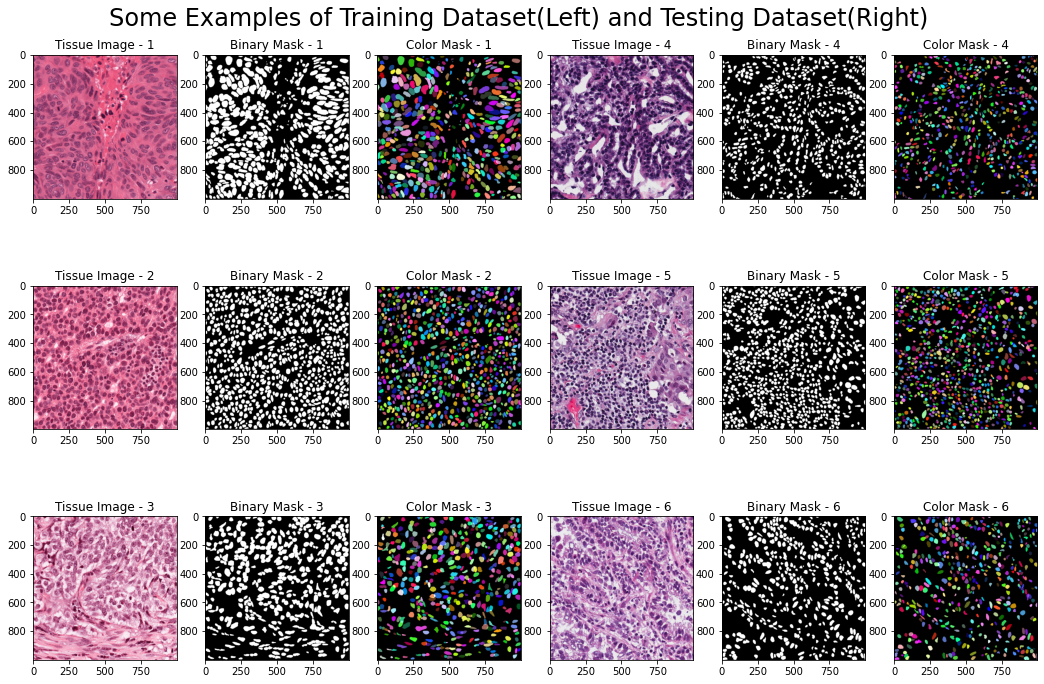

In [5]:
plt.rcParams["figure.figsize"] = [18.00, 11.00]
plt.suptitle('Some Examples of Training Dataset(Left) and Testing Dataset(Right)', fontsize = 24)

for i in range(3):
  img = Image.open(train_data["image"][i])
  bmask = Image.open(train_data["binary-mask"][i])
  cmask = Image.open(train_data["color-mask"][i])
  plt.subplot(3,6, 6*i + 1)
  plt.imshow(np.asarray(img))
  plt.title('Tissue Image - ' + str(i+1))
  plt.subplot(3,6, 6*i + 2)
  plt.imshow(np.asarray(bmask), cmap = 'gray')
  plt.title('Binary Mask - ' + str(i+1))
  plt.subplot(3,6, 6*i + 3)
  plt.imshow(np.asarray(cmask))
  plt.title('Color Mask - ' + str(i+1))

  img = Image.open(test_data["image"][i])
  bmask = Image.open(test_data["binary-mask"][i])
  cmask = Image.open(test_data["color-mask"][i])
  plt.subplot(3,6, 6*i + 4)
  plt.imshow(np.asarray(img))
  plt.title('Tissue Image - ' + str(i+4))
  plt.subplot(3,6, 6*i + 5)
  plt.imshow(np.asarray(bmask), cmap = 'gray')
  plt.title('Binary Mask - ' + str(i+4))
  plt.subplot(3,6, 6*i + 6)
  plt.imshow(np.asarray(cmask))
  plt.title('Color Mask - ' + str(i+4))

plt.subplots_adjust(top = 0.95)
plt.show()

---
2. Code a basic UNet for semantic segmentation in TF+Keras or Pytorch for the binary nucleus vs. non-nucleus segmentation. You may leave a small margin of pixels all around the image from the output. 

In [6]:
import torch
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module
from torch.nn import BatchNorm2d, ReLU, Sigmoid
from torch.optim import Adam
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Resize both the image and the mask to the desired size
class Resize(object):
  def __init__(self, output_size):
    self.output_size = output_size

  def __call__(self, sample):
    image, mask = sample["image"], sample["binary-mask"]
    image = image.resize(self.output_size)
    mask = Image.fromarray(mask).resize(self.output_size)
    return {"image" : image, "binary-mask" : mask}

# To add paddings to the mask to ignore the effect around the borders of the mask
class PadBorders(object):
  def __call__(self, sample):
    image, mask = sample["image"], sample["binary-mask"]
    h, w = mask.size
    mask = mask.crop((10, 10, h-10, w-10))
    mask = np.pad(np.array(mask), 10)
    return {"image" : image, "binary-mask" : mask}

# Converting the image and mask to tensor and normalizing the image to the norm of the images
class ToTensor(object):
  def __call__(self, sample):
    image, mask = sample["image"], sample["binary-mask"]
    convert = transforms.ToTensor()
    image = convert(image)
    mask = convert(mask)
    return {"image" : image, "binary-mask" : mask}

In [8]:
# Composition of the defined transforms to be applied to the images
transform = transforms.Compose([
    PadBorders(), 
    Resize((512,512)),
    ToTensor(),
])

In [9]:
# My Dataset class which takes the image and mask paths and the transforms 
# and applies them on the images
class MyDataset(Dataset):
  def __init__(self, img_path, bmask_path, transforms):
    self.img_path = img_path 
    self.bmask_path = bmask_path 
    self.transforms = transforms 

  def __len__(self):
    return len(self.img_path)
  
  def __getitem__(self, idx):
    image = Image.open(self.img_path[idx])
    bmask = Image.open(self.bmask_path[idx])
    sample = {"image" : image, "binary-mask" : bmask}
    if self.transforms:
      sample = self.transforms(sample)
    return sample

Now to make the UNet architecture, below is the architecture of the basic UNet:
<img src = 'https://drive.google.com/uc?id=1xFDGiF2Vc6-AFxYuqYhY8wysadckEg7h' width = "900">
<br>There are two filters per layer and there are 4 layers in total. So there will be an Encoding layer which has convolutional layers and a max pooling layer which reduces the size of input by a factor of 2. And there will be a Decoding block which will upscale the input by 2 and pass it through the convolutional layers. Each layer encoding and decoding blocks have equal convolutianl filters and are connected as the encoding data is used in upscaling in the decoding part.

In [10]:
# This block has variable number of convolutional layers 
class Block(Module):
  def __init__(self, filters, in_ch, out_ch):
    super().__init__()
    self.conv = Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1)
    self.bn = BatchNorm2d(out_ch)
    self.relu = ReLU()
    self.recurr = lambda x : x
    if filters > 1:
      self.recurr = Block(filters-1, out_ch, out_ch) 
    
  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.recurr(x)
    return x

In [11]:
# This is the encoding block which gives the output after conv layers and
# it also gives the max pooled output which is reduced in size
class Encoder(Module):
  def __init__(self, filters, in_ch, out_ch):
    super().__init__()
    self.conv_layers = Block(filters, in_ch, out_ch)
    self.pool = MaxPool2d((2,2))

  def forward(self, x):
    x = self.conv_layers(x)
    p = self.pool(x)
    return x, p 

In [12]:
# This is the decoding block which takes in the previous input from the encoding block
# and upscales the previous input from the previous decoder and passes both of them
# through the convolutional layers
class Decoder(Module):
  def __init__(self, filters, in_ch, out_ch):
    super().__init__() 
    self.upconv = ConvTranspose2d(in_ch, out_ch, kernel_size = (2,2), stride = 2, padding = 0)
    self.conv_layers = Block(filters, 2*out_ch, out_ch)

  def forward(self, x, p):
    x = self.upconv(x)
    x = torch.cat([x, p], axis = 1)
    x = self.conv_layers(x)
    return x

In [13]:
# Defining the Recurring layers of the UNet architecture
class RecurrNet(Module):
  def __init__(self, layers, filters, dim1, dim2):
    super().__init__()
    self.encoder = Encoder(filters, dim1, dim2)
    self.decoder = Decoder(filters, 2*dim2, dim2)
    self.recurr = Block(filters, dim2, 2*dim2)
    if layers > 1:
      self.recurr = RecurrNet(layers-1, filters, dim2, 2*dim2)

  def forward(self, x):
    s, p = self.encoder(x)
    b = self.recurr(p)
    d = self.decoder(b, s)
    return d

In [14]:
# Finally adding an output layer to the network and a sigmoid activation
class MyUNet(Module):
  def __init__(self, layers, filters):
    super().__init__()
    self.recurr = RecurrNet(layers, filters, 3, 64)
    self.output = Conv2d(64, 1, kernel_size = 1, padding = 0)
    self.sigmoid = Sigmoid()
  
  def forward(self, x):
    d = self.recurr(x)
    outputs = self.output(d)
    outputs = self.sigmoid(outputs)
    return outputs

In [29]:
# Defining the Basic UNet with 4 layers and 2 filters in each layer
device = "cuda" if torch.cuda.is_available() else "cpu"

unet_basic = MyUNet(4, 2).to(device)

summary(unet_basic, (1, 3, 512, 512))

Layer (type:depth-idx)                                       Output Shape              Param #
MyUNet                                                       [1, 1, 512, 512]          --
├─RecurrNet: 1-1                                             [1, 64, 512, 512]         --
│    └─Encoder: 2-1                                          [1, 64, 512, 512]         --
│    │    └─Block: 3-1                                       [1, 64, 512, 512]         38,976
│    │    └─MaxPool2d: 3-2                                   [1, 64, 256, 256]         --
│    └─RecurrNet: 2-2                                        [1, 128, 256, 256]        --
│    │    └─Encoder: 3-3                                     [1, 128, 256, 256]        221,952
│    │    └─RecurrNet: 3-4                                   [1, 256, 128, 128]        30,064,384
│    │    └─Decoder: 3-5                                     [1, 128, 256, 256]        574,336
│    └─Decoder: 2-3                                          [1, 64, 512,

---
3. Train the UNet using Dice Loss, and show Dice score on validation and test data. 

In [30]:
# Defining the Dice Score and the Dice Loss for the model
def DiceScore(targets, inputs):
  inputs = inputs.view(-1)
  targets = targets.view(-1)
  intersection = (inputs * targets).sum()
  dice = (2.0 * intersection) / (inputs.sum() + targets.sum())
  return dice 

def DiceLoss(targets, inputs):
  return 1 - DiceScore(targets, inputs)

In [31]:
split = train_test_split(train_data["image"], train_data["binary-mask"], test_size = 0.1, shuffle = True)

train_ds = {"image" : [], "binary-mask" : []}
val_ds = {"image" : [], "binary-mask" : []}
test_ds = {"image" : [], "binary-mask" : []}

(train_ds["image"], val_ds["image"]) = split[:2]
(train_ds["binary-mask"], val_ds["binary-mask"]) = split[2:]
test_ds["image"] = test_data["image"]
test_ds["binary-mask"] = test_data["binary-mask"]

In [32]:
# Defining the Datasets for all train, test and val sets
train_ds = MyDataset(train_ds["image"], train_ds["binary-mask"], transform)
val_ds = MyDataset(val_ds["image"], val_ds["binary-mask"], transform)
test_ds = MyDataset(test_ds["image"], test_ds["binary-mask"], transform)

# Then defining the DataLoader for this to be used in the model
train_dl = DataLoader(train_ds, shuffle = True, batch_size = 1)
val_dl = DataLoader(val_ds, shuffle = True, batch_size = 1)
test_dl = DataLoader(test_ds, shuffle = True, batch_size = 1)      

In [33]:
optim = Adam(unet_basic.parameters(), lr = 1e-2)
train_steps = len(train_ds)
val_steps = len(val_ds)
test_steps = len(test_ds) 
loss = DiceLoss
epochs = 20
H = {"train_loss": [], "val_loss": []}

In [135]:
from google.colab import output
from tqdm.notebook import tqdm_notebook

for e in tqdm_notebook(range(epochs)):
  unet_basic.train()
  total_train_loss = 0
  total_val_loss = 0

  for (i, sample) in enumerate(train_dl):
    x, y = sample["image"], sample["binary-mask"]
    x, y = x.to(device), y.to(device)
    pred = unet_basic(x)
    loss = DiceLoss(y, pred)
    optim.zero_grad()
    loss.backward()
    optim.step()

    total_train_loss += loss
  
  with torch.no_grad():
    unet_basic.eval()
    for sample in val_dl: 
      x, y = sample["image"], sample["binary-mask"]
      x, y = x.to(device), y.to(device)
      pred = unet_basic(x)
      total_val_loss += DiceLoss(y, pred)
  
  avg_train_loss = total_train_loss / train_steps
  avg_val_loss = total_val_loss / val_steps 

  H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
  H["val_loss"].append(avg_val_loss.cpu().detach().numpy())
  output.clear()
  print("EPOCH: {}/{}".format(e + 1, epochs))
  print("Train loss: {:.6f}, Val loss: {:.4f}".format(avg_train_loss, avg_val_loss))

EPOCH: 20/20
Train loss: 0.187891, Val loss: 0.2223


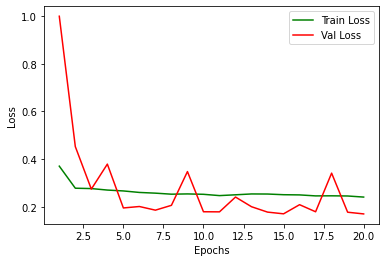

In [35]:
plt.rcParams['figure.figsize'] = [6,4]
plt.plot([x+1 for x in range(epochs)], H["train_loss"], 'g', label = 'Train Loss')
plt.plot([x+1 for x in range(epochs)], H["val_loss"], 'r', label = 'Val Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [136]:
# Dice Score on the Validation dataset
total_val_loss = 0
with torch.no_grad():
    unet_basic.eval()
    for sample in val_dl:
      x, y = sample["image"].to(device), sample["binary-mask"].to(device)
      pred = unet_basic(x)
      total_val_loss += DiceLoss(pred, y)
total_val_loss = total_val_loss/val_steps

# Dice Score on the Testing dataset
total_test_loss = 0
with torch.no_grad():
    unet_basic.eval()
    for sample in test_dl:
      x, y = sample["image"].to(device), sample["binary-mask"].to(device)
      pred = unet_basic(x)
      total_test_loss += DiceLoss(pred, y)
total_test_loss = total_test_loss/test_steps

print("Val Dice Score  :", 1-total_val_loss.cpu().detach().numpy())
print("Test Dice Score :", 1-total_test_loss.cpu().detach().numpy())

Val Dice Score  : 0.7776866257190704
Test Dice Score : 0.6102340519428253



---


4. Show a few output maps.


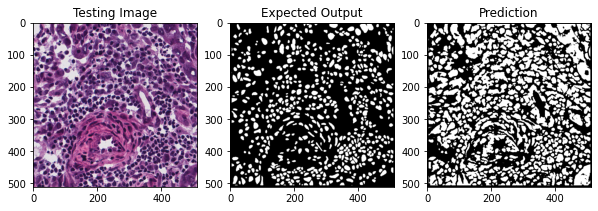

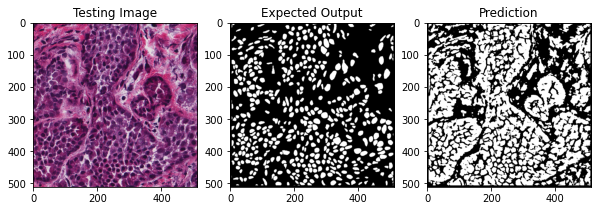

In [137]:
i = 0
with torch.no_grad():
    unet_basic.eval()
    for sample in test_dl:
      x, y = sample["image"].to(device), sample["binary-mask"].to(device)
      pred = unet_basic(x)
      pred = ((pred - pred.min())/(1 - pred.min())).float()
      convert = transforms.ToPILImage()
      pred = np.array(convert(pred[0]))
      x = np.array(convert(x[0]))
      y = np.array(convert(y[0]))
      fig = plt.figure(figsize = (10,25))
      fig.add_subplot(1, 3, 1)
      plt.imshow(x)
      plt.title('Testing Image')
      fig.add_subplot(1, 3, 2)
      plt.imshow(y, cmap = 'gray')
      plt.title('Expected Output')
      fig.add_subplot(1, 3, 3)
      plt.imshow(pred, cmap = 'gray')
      plt.title('Prediction')
      plt.show()
      i += 1
      if i == 2:
        break

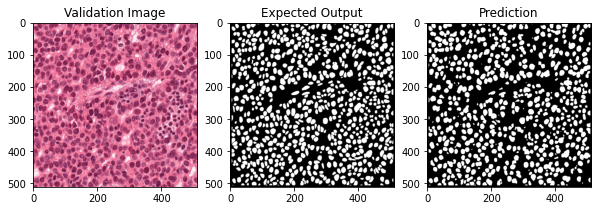

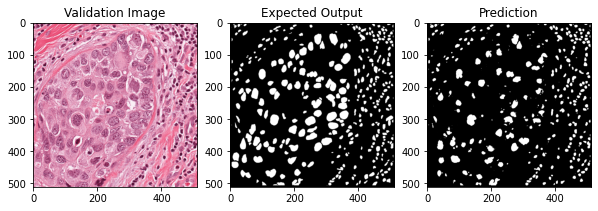

In [138]:
i = 0
with torch.no_grad():
    unet_basic.eval()
    for sample in val_dl:
      x, y = sample["image"].to(device), sample["binary-mask"].to(device)
      pred = unet_basic(x)
      convert = transforms.ToPILImage()
      pred = np.array(convert(pred[0]))
      x = np.array(convert(x[0]))
      y = np.array(convert(y[0]))
      fig = plt.figure(figsize = (10,25))
      fig.add_subplot(1, 3, 1)
      plt.imshow(x)
      plt.title('Validation Image')
      fig.add_subplot(1, 3, 2)
      plt.imshow(y, cmap = 'gray')
      plt.title('Expected Output')
      fig.add_subplot(1, 3, 3)
      plt.imshow(pred, cmap = 'gray')
      plt.title('Prediction')
      plt.show()
      i += 1
      if i == 2:
        break

In [39]:
torch.save(unet_basic.state_dict(), '/content/drive/MyDrive/unet_basic.pt')

---
5. Modify this baseline architecture to study the impact of changing:
<br> a. Number of blocks in the UNet architecture. 
<br> b. Number of filters per layer in the UNet architecture. 
<br> c. Loss function as a combination of Dice and MS-SSIM with a trade-off parameter. 

In [40]:
!pip install torchmetrics
from torchmetrics import MultiScaleStructuralSimilarityIndexMeasure
import gc
from tqdm.notebook import tqdm_notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
# Defining a general training model 
def trainModel(layers, filters, epochs, tradeoff):
  def Loss(targets, inputs, tradeoff):
    MS_SSIM = MultiScaleStructuralSimilarityIndexMeasure(data_range = 1.0).to(device)
    loss = tradeoff*DiceLoss(targets, inputs) + (1 - tradeoff)*(1-MS_SSIM(targets, inputs))
    return loss  

  unet = MyUNet(layers, filters).to(device)  
  optim = Adam(unet.parameters(), lr = 1e-3)

  train_steps = len(train_ds)
  val_steps = len(val_ds)

  H = {"train_loss": [], "val_loss": []}

  for e in tqdm_notebook(range(epochs)):
    unet.train()
    total_train_loss = 0
    total_val_loss = 0

    for (i, sample) in enumerate(train_dl):
      x, y = sample["image"].to(device), sample["binary-mask"].to(device)
      pred = unet(x)
      loss = Loss(y, pred, tradeoff)
      optim.zero_grad()
      loss.backward()
      optim.step()

      total_train_loss += loss
    
    with torch.no_grad():
      unet.eval()
      for sample in val_dl:
        x, y = sample["image"].to(device), sample["binary-mask"].to(device)
        pred = unet(x)
        total_val_loss += Loss(y, pred, tradeoff)
    
    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps 

    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    print("EPOCH: {}/{}".format(e + 1, epochs))
    print("Train loss: {:.6f}, Val loss: {:.4f}".format(avg_train_loss, avg_val_loss))
  return H

In [45]:
LAYERS = [4,5]
FILTERS = [2,3]
TRADEOFF = [0.8, 0.9]
EPOCHS = 10

Losses = []

for layers in LAYERS:
  for filters in FILTERS:
    for tradeoff in TRADEOFF:
      print(f"Training for layers : {layers}, filters: {filters}, tradeoff: {tradeoff}")
      H = trainModel(layers, filters, EPOCHS, tradeoff)
      Losses.append({
          'layers': layers,
          'filters': filters,
          'epochs': EPOCHS,
          'tradeoff': tradeoff,
          'loss': H
      })
      gc.collect()
      torch.cuda.empty_cache()

Training for layers : 4, filters: 2, tradeoff: 0.8


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10
Train loss: 0.399649, Val loss: 0.3486
EPOCH: 2/10
Train loss: 0.325546, Val loss: 0.2551
EPOCH: 3/10
Train loss: 0.297797, Val loss: 0.2367
EPOCH: 4/10
Train loss: 0.279177, Val loss: 0.1848
EPOCH: 5/10
Train loss: 0.266724, Val loss: 0.1796
EPOCH: 6/10
Train loss: 0.261476, Val loss: 0.1761
EPOCH: 7/10
Train loss: 0.245290, Val loss: 0.1593
EPOCH: 8/10
Train loss: 0.235706, Val loss: 0.1609
EPOCH: 9/10
Train loss: 0.230156, Val loss: 0.1900
EPOCH: 10/10
Train loss: 0.225403, Val loss: 0.1479
Training for layers : 4, filters: 2, tradeoff: 0.9


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10
Train loss: 0.401074, Val loss: 0.4058
EPOCH: 2/10
Train loss: 0.330012, Val loss: 0.2789
EPOCH: 3/10
Train loss: 0.296767, Val loss: 0.2303
EPOCH: 4/10
Train loss: 0.278142, Val loss: 0.1856
EPOCH: 5/10
Train loss: 0.258819, Val loss: 0.1820
EPOCH: 6/10
Train loss: 0.254313, Val loss: 0.1675
EPOCH: 7/10
Train loss: 0.237147, Val loss: 0.1729
EPOCH: 8/10
Train loss: 0.225085, Val loss: 0.1535
EPOCH: 9/10
Train loss: 0.229154, Val loss: 0.1521
EPOCH: 10/10
Train loss: 0.221463, Val loss: 0.1635
Training for layers : 4, filters: 3, tradeoff: 0.8


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10
Train loss: 0.404018, Val loss: 0.4889
EPOCH: 2/10
Train loss: 0.329508, Val loss: 0.3110
EPOCH: 3/10
Train loss: 0.302526, Val loss: 0.2880
EPOCH: 4/10
Train loss: 0.285509, Val loss: 0.2669
EPOCH: 5/10
Train loss: 0.278830, Val loss: 0.2008
EPOCH: 6/10
Train loss: 0.266319, Val loss: 0.8384
EPOCH: 7/10
Train loss: 0.264523, Val loss: 0.1878
EPOCH: 8/10
Train loss: 0.256862, Val loss: 0.1892
EPOCH: 9/10
Train loss: 0.247312, Val loss: 0.2814
EPOCH: 10/10
Train loss: 0.249495, Val loss: 0.1996
Training for layers : 4, filters: 3, tradeoff: 0.9


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10
Train loss: 0.386468, Val loss: 0.3153
EPOCH: 2/10
Train loss: 0.320300, Val loss: 0.2517
EPOCH: 3/10
Train loss: 0.294480, Val loss: 0.3033
EPOCH: 4/10
Train loss: 0.277838, Val loss: 0.1856
EPOCH: 5/10
Train loss: 0.260840, Val loss: 0.3188
EPOCH: 6/10
Train loss: 0.264936, Val loss: 0.2221
EPOCH: 7/10
Train loss: 0.254593, Val loss: 0.1852
EPOCH: 8/10
Train loss: 0.247893, Val loss: 0.1974
EPOCH: 9/10
Train loss: 0.246795, Val loss: 0.1807
EPOCH: 10/10
Train loss: 0.240159, Val loss: 0.2239
Training for layers : 5, filters: 2, tradeoff: 0.8


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10
Train loss: 0.408546, Val loss: 0.3431
EPOCH: 2/10
Train loss: 0.343169, Val loss: 0.2555
EPOCH: 3/10
Train loss: 0.309260, Val loss: 0.2543
EPOCH: 4/10
Train loss: 0.289731, Val loss: 0.2436
EPOCH: 5/10
Train loss: 0.270132, Val loss: 0.2124
EPOCH: 6/10
Train loss: 0.260291, Val loss: 0.1716
EPOCH: 7/10
Train loss: 0.250128, Val loss: 0.1935
EPOCH: 8/10
Train loss: 0.246825, Val loss: 0.2155
EPOCH: 9/10
Train loss: 0.239520, Val loss: 0.1647
EPOCH: 10/10
Train loss: 0.230962, Val loss: 0.1847
Training for layers : 5, filters: 2, tradeoff: 0.9


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10
Train loss: 0.427900, Val loss: 0.4414
EPOCH: 2/10
Train loss: 0.355377, Val loss: 0.2788
EPOCH: 3/10
Train loss: 0.324623, Val loss: 0.2184
EPOCH: 4/10
Train loss: 0.294853, Val loss: 0.2162
EPOCH: 5/10
Train loss: 0.269609, Val loss: 0.1972
EPOCH: 6/10
Train loss: 0.257233, Val loss: 0.4934
EPOCH: 7/10
Train loss: 0.250777, Val loss: 0.1661
EPOCH: 8/10
Train loss: 0.242660, Val loss: 0.1704
EPOCH: 9/10
Train loss: 0.233336, Val loss: 0.1770
EPOCH: 10/10
Train loss: 0.228791, Val loss: 0.1655
Training for layers : 5, filters: 3, tradeoff: 0.8


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10
Train loss: 0.410654, Val loss: 0.4331
EPOCH: 2/10
Train loss: 0.341556, Val loss: 0.4333
EPOCH: 3/10
Train loss: 0.319003, Val loss: 0.2292
EPOCH: 4/10
Train loss: 0.293658, Val loss: 0.2133
EPOCH: 5/10
Train loss: 0.282390, Val loss: 0.2306
EPOCH: 6/10
Train loss: 0.269529, Val loss: 0.1793
EPOCH: 7/10
Train loss: 0.263276, Val loss: 0.1803
EPOCH: 8/10
Train loss: 0.253607, Val loss: 0.1744
EPOCH: 9/10
Train loss: 0.252820, Val loss: 0.2088
EPOCH: 10/10
Train loss: 0.243224, Val loss: 0.2216
Training for layers : 5, filters: 3, tradeoff: 0.9


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1/10
Train loss: 0.420122, Val loss: 0.3424
EPOCH: 2/10
Train loss: 0.340494, Val loss: 0.3168
EPOCH: 3/10
Train loss: 0.313530, Val loss: 0.2329
EPOCH: 4/10
Train loss: 0.294986, Val loss: 0.2535
EPOCH: 5/10
Train loss: 0.285116, Val loss: 0.1957
EPOCH: 6/10
Train loss: 0.272174, Val loss: 0.5907
EPOCH: 7/10
Train loss: 0.266992, Val loss: 0.4432
EPOCH: 8/10
Train loss: 0.259158, Val loss: 0.1962
EPOCH: 9/10
Train loss: 0.249140, Val loss: 0.1801
EPOCH: 10/10
Train loss: 0.245481, Val loss: 0.1725


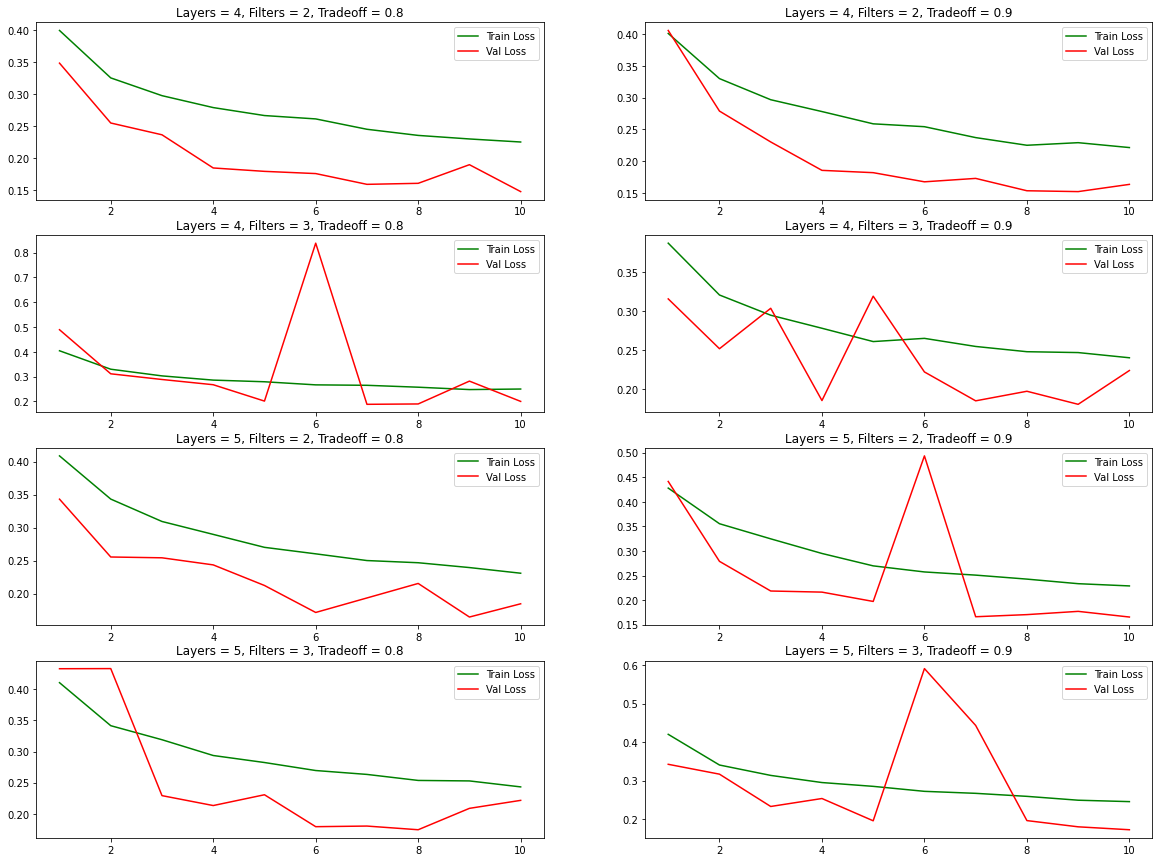

In [46]:
N = len(LAYERS)*len(FILTERS)
M = len(TRADEOFF)
fig, axs = plt.subplots(N, M)
fig.set_figheight(15)
fig.set_figwidth(20)
for i in range(N):
  for j in range(M):
    k = i*M+j
    axs[i,j].plot([x+1 for x in range(Losses[k]['epochs'])], Losses[k]['loss']["train_loss"], 'g', label = 'Train Loss')
    axs[i,j].plot([x+1 for x in range(Losses[k]['epochs'])], Losses[k]['loss']["val_loss"], 'r', label = 'Val Loss')
    axs[i,j].legend()
    axs[i,j].set_title(f"Layers = {Losses[k]['layers']}, Filters = {Losses[k]['filters']}, Tradeoff = {Losses[k]['tradeoff']}")
plt.show()

Best train and val loss are for layers = 4, filters = 2 and tradeoff = 0.9

---
6. Use watershed segmentation on the probability map produced by the UNet to segment individual nuclei, and show results on test images with touching or overlapping nuclei. Experiment with various parameters of watershed algorithms to try to improve the results.

In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
from skimage.segmentation import clear_border

In [121]:
def watershed_alg(mask):
  ret1, thresh = cv2.threshold(mask, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Morphological operations to remove small noise - opening
  #To remove holes we can use closing
  kernel = np.ones((3,3),np.float32)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

  opening = clear_border(opening)  
  sure_bg = cv2.dilate(opening,kernel,iterations=2)
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)

  #Let us threshold the dist transform by 20% its max value.
  ret2, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)
 
  ret3, markers = cv2.connectedComponents(sure_fg)

  #One problem rightnow is that the entire background pixels is given value 0.
  #This means watershed considers this region as unknown.
  #So let us add 10 to all labels so that sure background is not 0, but 10
  markers = markers+10

  # Now, mark the region of unknown with zero
  markers[unknown==255] = 0

  #Now we are ready for watershed filling. 
  mask1 = np.ones((mask.shape[0], mask.shape[1], 3))
  mask1[:,:, 0] = mask
  mask1[:,:, 1] = mask
  mask1[:,:, 2] = mask
  markers = cv2.watershed( mask1.astype(np.uint8), markers)
  
  img2 = color.label2rgb(markers, bg_label=10)
  return img2

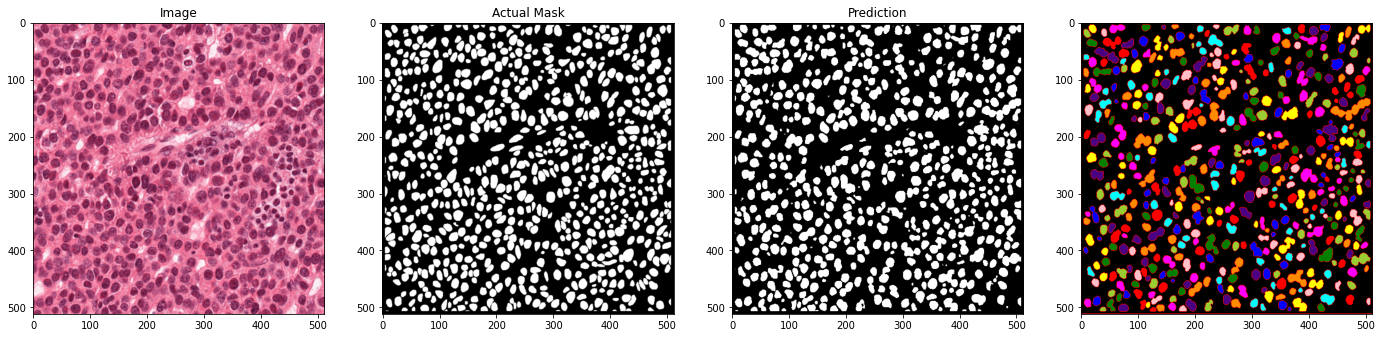

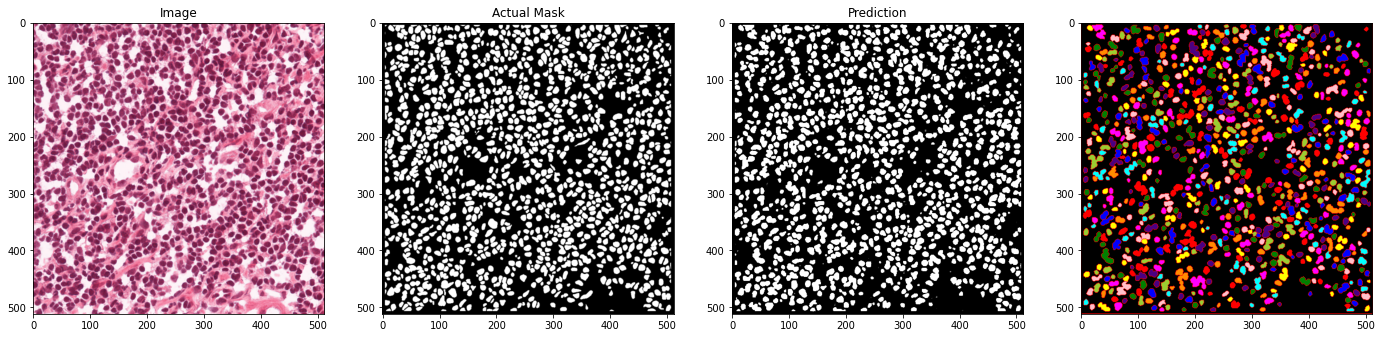

In [139]:
# Watershed for some Validation Images for the Basic Unet model trained earlier
i = 0
with torch.no_grad():
    unet_basic.eval()
    for sample in val_dl:
      x, y = sample["image"].to(device), sample["binary-mask"].to(device)
      pred = unet_basic(x)
      convert = transforms.ToPILImage()
      pred = np.array(convert(pred[0]))
      x = np.array(convert(x[0]))
      y = np.array(convert(y[0]))
      fig = plt.figure(figsize = (24,6))
      fig.add_subplot(1, 4, 1)
      plt.imshow(x)
      plt.title('Image')
      fig.add_subplot(1, 4, 2)
      plt.imshow(y, cmap = 'gray')
      plt.title('Actual Mask')
      fig.add_subplot(1, 4, 3)
      plt.imshow(pred, cmap = 'gray')
      plt.title('Prediction')
      fig.add_subplot(1, 4, 4)
      plt.imshow(watershed_alg(pred))
      plt.show()
      i += 1
      if i == 2:
        break

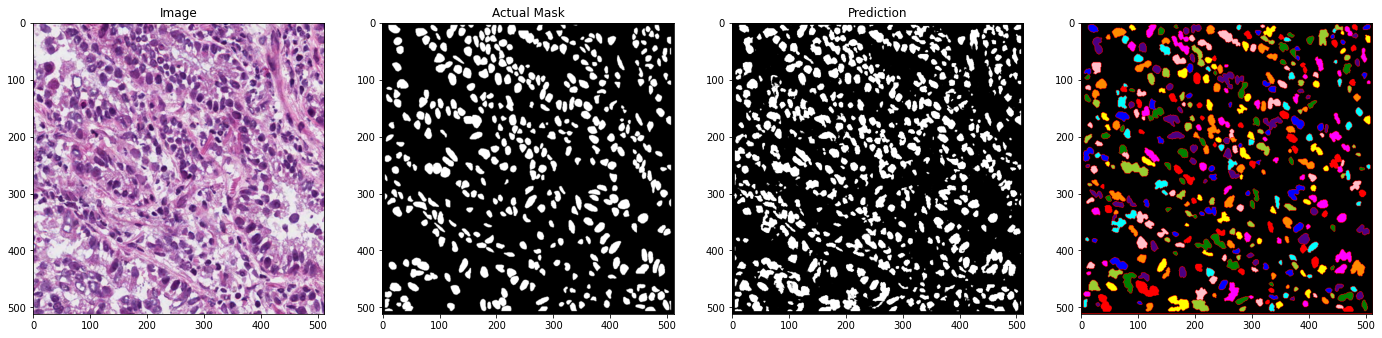

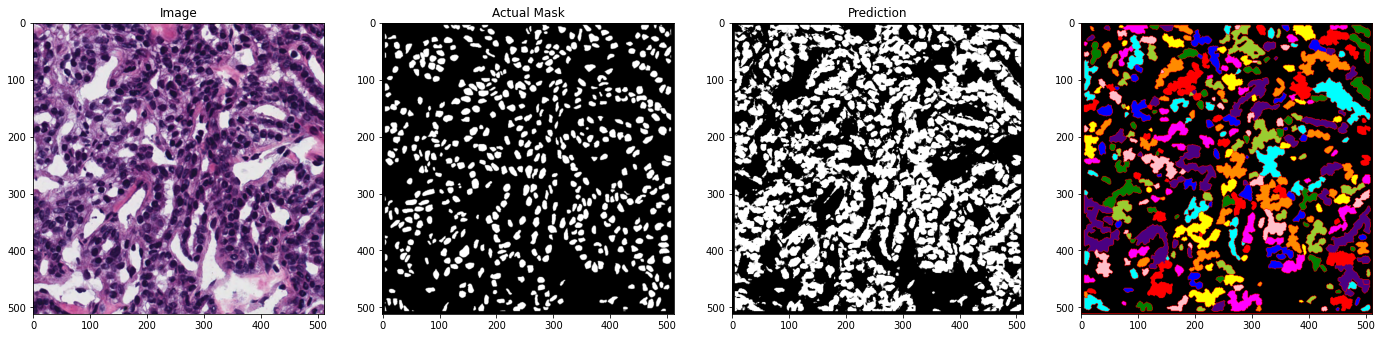

In [140]:
# Watershed for some Testing Images for the Basic Unet model trained earlier
i = 0
with torch.no_grad():
    unet_basic.eval()
    for sample in test_dl:
      x, y = sample["image"].to(device), sample["binary-mask"].to(device)
      pred = unet_basic(x)
      convert = transforms.ToPILImage()
      pred = np.array(convert(pred[0]))
      x = np.array(convert(x[0]))
      y = np.array(convert(y[0]))
      fig = plt.figure(figsize = (24,6))
      fig.add_subplot(1, 4, 1)
      plt.imshow(x)
      plt.title('Image')
      fig.add_subplot(1, 4, 2)
      plt.imshow(y, cmap = 'gray')
      plt.title('Actual Mask')
      fig.add_subplot(1, 4, 3)
      plt.imshow(pred, cmap = 'gray')
      plt.title('Prediction')
      fig.add_subplot(1, 4, 4)
      plt.imshow(watershed_alg(pred))
      plt.show()
      i += 1
      if i == 2:
        break

--- 
--- 
#Refrences 
1. https://github.com/milesial/Pytorch-UNet 
2. https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
3. https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html 
4. https://docs.opencv.org/3.3.1/d7/d1b/group__imgproc__misc.html#ga3267243e4d3f95165d55a618c65ac6e1 
5. https://github.com/bnsreenu/python_for_microscopists/blob/master/033-grain_size_analysis_using_wateshed_segmentation.py